In [177]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import cmocean
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

# Summary
This notebooks opens the NOBM-OASIM dataset with PC scores and standardizes the env variables. It opens all the phyto .csv's that contain the MLR selected variables, coefficients, and intercept. It applies each MLR model to all phyto data > 0.01 and creates new scatterplots and maps.  

# Read in dataset w/ scores

In [178]:
rrs_xds = xr.open_dataset('/glusteruser/awindled/ALL_NOBM_OASIM_data_2020_w_scores.nc', decode_times=False)
rrs_xds 

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/55)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    PC_3            (months, lat, lon) float64 ...
    PC_4            (months, lat, lon) float64 ...
    PC_5            (months, lat, lon) float64 ...
    PC_6            (months, lat, lon) float64 ...
    PC_7            (months, lat, lon) float64 ...
    PC_8            (months, lat, lon) float64 ...

# Standardize env variables (values range from 0-1)

In [179]:
env_vars = ['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for i in range(len(env_vars)):
    foo = rrs_xds[env_vars[i]].values.reshape(12*234*288)
    foo = scaler.fit_transform(foo.reshape(-1, 1))
    rrs_xds[env_vars[i]].values = foo.reshape(12,234,288)

# Make new variables of logged phyto

In [180]:
log_phyto_vars = ['log_tot', 'log_chl', 'log_dia', 'log_coc', 'log_cya', 'log_din', 'log_pha']
phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

for i in range(len(log_phyto_vars)):
    rrs_xds[log_phyto_vars] = np.log10(rrs_xds[phyto_vars])
rrs_xds    

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/62)
    tot             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    chl             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    dia             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    coc             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    cya             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    din             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    ...              ...
    log_chl         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_dia         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_coc         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_cya         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_din         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_pha         (months, lat, lon) float32 nan nan nan nan ... nan nan nan

# Read in csv's that contain selected_features, coefs, and int for each phyto

In [181]:
tot = pd.read_csv('/glusteruser/awindled/tot.csv')
tot.name = 'tot'
chl = pd.read_csv('/glusteruser/awindled/chl.csv')
chl.name = 'chl'
dia = pd.read_csv('/glusteruser/awindled/dia.csv')
dia.name = 'dia'
coc = pd.read_csv('/glusteruser/awindled/coc.csv')
coc.name = 'coc'
cya = pd.read_csv('/glusteruser/awindled/cya.csv')
cya.name = 'cya'
din = pd.read_csv('/glusteruser/awindled/din.csv')
din.name = 'din'
pha = pd.read_csv('/glusteruser/awindled/pha.csv')
pha.name = 'pha'

# For each phyto group, stack the dataset, and apply MLR model to pixels that have phyto conc > 0.01. Save predicted results as a list

In [230]:
def apply_MLR(phyto_csv):

    phyto = phyto_csv.name[0:3]
    
    vars = phyto_csv.selected_features.to_list()
    vars.extend(['log_tot', 'log_chl', 'log_dia', 'log_coc', 'log_cya', 'log_din', 'log_pha', 'tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'])

    rrs_xds_phyto = rrs_xds[vars]
    rrs_xds_phyto_stacked = rrs_xds_phyto.stack(z=("lat", "lon", "months"))

    pred_phyto = []
    for i in range(len(rrs_xds_phyto_stacked['log_'+phyto])):
        foo_all = []
        if rrs_xds_phyto_stacked[phyto].values[i] > 0.01:
            for j in range(len(phyto_csv.coefs_mn)):
                foo = phyto_csv.coefs_mn[j] * rrs_xds_phyto_stacked[phyto_csv.selected_features[j]][i].values
                foo_all.append(foo)
                phyto_value = np.mean(phyto_csv.int) + np.sum(foo_all)
        else:
            phyto_value = np.nan
        pred_phyto.append(phyto_value)
    
    pred_phyto = np.array(pred_phyto)
    
    return pred_phyto

In [231]:
pred_log_tot = apply_MLR(phyto_csv=tot)
#pred_log_chl = apply_MLR(phyto_csv=chl)
#pred_log_dia = apply_MLR(phyto_csv=dia)
#pred_log_coc = apply_MLR(phyto_csv=coc)
#pred_log_cya = apply_MLR(phyto_csv=cya)
#pred_log_din = apply_MLR(phyto_csv=din)
#pred_log_pha = apply_MLR(phyto_csv=pha)


# add predicted log phyto groups to stacked dataset

In [288]:
vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha', 'log_tot', 'log_chl', 'log_dia', 'log_coc', 'log_cya', 'log_din', 'log_pha']

rrs_xds_phyto = rrs_xds[vars]
rrs_xds_phyto_stacked = rrs_xds_phyto.stack(z=("lat", "lon", "months"))
rrs_xds_phyto_stacked = rrs_xds_phyto_stacked.assign(pred_log_tot=("z", pred_log_tot))#,
                                                #pred_log_chl=("z", pred_log_chl), pred_log_dia=("z", pred_log_dia))
rrs_xds_phyto_stacked

<xarray.Dataset>
Dimensions:       (z: 808704)
Coordinates:
  * z             (z) object MultiIndex
  * lat           (z) float32 -84.0 -84.0 -84.0 -84.0 ... 71.33 71.33 71.33
  * lon           (z) float32 -180.0 -180.0 -180.0 -180.0 ... 178.8 178.8 178.8
  * months        (z) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 7.0 8.0 9.0 10.0 11.0
Data variables: (12/15)
    tot           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    chl           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    dia           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    coc           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    cya           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    din           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    ...            ...
    log_dia       (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    log_coc       (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    log_cya       (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    log_din       (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    log_pha       (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    pred_log_tot  (z) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [303]:
vars = ['log_tot', 'log_chl', 'log_dia', 'log_coc', 'log_cya', 'log_din', 'log_pha']

for i in range(len(vars)):
    #rrs_xds_phyto_stacked[vars[i]] = xr.where(rrs_xds_phyto_stacked[vars[i]] > (10**0.01), rrs_xds_phyto_stacked[vars[i]], np.nan)
    rrs_xds_phyto_stacked[vars[i]] = rrs_xds_phyto_stacked[vars[i]].where(rrs_xds_phyto_stacked[vars[i]] < 10**0.01, other='nan')
rrs_xds_phyto_stacked

<xarray.Dataset>
Dimensions:       (z: 808704)
Coordinates:
  * z             (z) object MultiIndex
  * lat           (z) float32 -84.0 -84.0 -84.0 -84.0 ... 71.33 71.33 71.33
  * lon           (z) float32 -180.0 -180.0 -180.0 -180.0 ... 178.8 178.8 178.8
  * months        (z) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 7.0 8.0 9.0 10.0 11.0
Data variables: (12/15)
    tot           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    chl           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    dia           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    coc           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    cya           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    din           (z) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    ...            ...
    log_dia       (z) object 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    log_coc       (z) object 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    log_cya       (z) object 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    log_din       (z) object 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    log_pha       (z) object 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    pred_log_tot  (z) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [308]:
print(rrs_xds_phyto_stacked.log_tot.count())
print(rrs_xds_phyto_stacked.pred_log_tot.count())
print(rrs_xds_phyto_stacked.log_tot.shape)
print(rrs_xds_phyto_stacked.pred_log_tot.shape)


<xarray.DataArray 'log_tot' ()>
array(808704)
<xarray.DataArray 'pred_log_tot' ()>
array(473112)
(808704,)
(808704,)


In [312]:
rrs_xds_phyto_stacked.log_tot[334000]

<xarray.DataArray 'log_tot' ()>
array(-1.1285085678100586, dtype=object)
Coordinates:
    z        object (-20.0, 51.25, 4.0)
    lat      float32 -20.0
    lon      float32 51.25
    months   float32 4.0
Attributes:
    long_name:      total chlorophyll
    standard_name:  tot
    FillValue:      -9999.0
    units:          mg m-3
    valid_range:    [  0. 100.]

In [313]:
rrs_xds_phyto_stacked.pred_log_tot[334000]

<xarray.DataArray 'pred_log_tot' ()>
array(-1.03378923)
Coordinates:
    z        object (-20.0, 51.25, 4.0)
    lat      float32 -20.0
    lon      float32 51.25
    months   float32 4.0

# Plot observed vs predicted data for each phyto group

"\nplt.figure(2)\nfig, ax = plt.subplots()\nax.scatter(rrs_xds_phyto_stacked.log_chl, rrs_xds_phyto_stacked.pred_log_chl)\nax.axline((0, 0), slope=1)\nax.set_xlabel('Actual')\nax.set_ylabel('Predicted')\n\nplt.figure(3)\nfig, ax = plt.subplots()\nax.scatter(rrs_xds_phyto_stacked.log_dia, rrs_xds_phyto_stacked.pred_log_dia)\nax.axline((0, 0), slope=1)\nax.set_xlabel('Actual')\nax.set_ylabel('Predicted')\n"

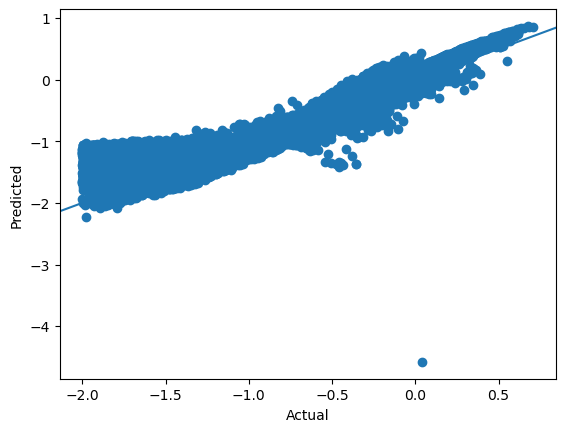

In [294]:
fig, ax = plt.subplots()

ax.scatter(rrs_xds_phyto_stacked.log_tot, rrs_xds_phyto_stacked.pred_log_tot)
ax.axline((0, 0), slope=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
'''
plt.figure(2)
fig, ax = plt.subplots()
ax.scatter(rrs_xds_phyto_stacked.log_chl, rrs_xds_phyto_stacked.pred_log_chl)
ax.axline((0, 0), slope=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

plt.figure(3)
fig, ax = plt.subplots()
ax.scatter(rrs_xds_phyto_stacked.log_dia, rrs_xds_phyto_stacked.pred_log_dia)
ax.axline((0, 0), slope=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
'''

"\nplt.figure(2)\nfig, ax = plt.subplots()\nax.scatter(rrs_xds_phyto_stacked.chl, 10**rrs_xds_phyto_stacked.pred_log_chl)\nax.axline((0, 0), slope=1)\nax.set_xlabel('Actual')\nax.set_ylabel('Predicted')\n\nplt.figure(3)\nfig, ax = plt.subplots()\nax.scatter(rrs_xds_phyto_stacked.dia, 10**rrs_xds_phyto_stacked.pred_log_dia)\nax.axline((0, 0), slope=1)\nax.set_xlabel('Actual')\nax.set_ylabel('Predicted')\n"

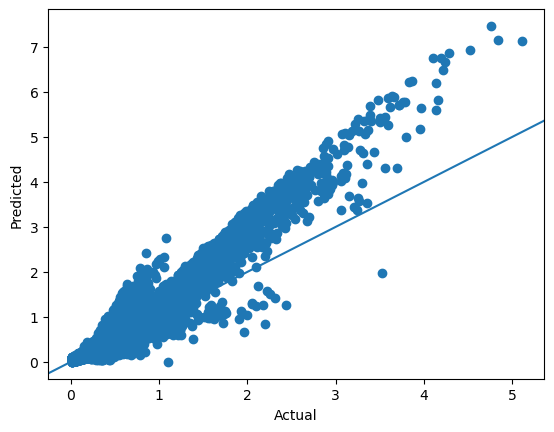

In [296]:
fig, ax = plt.subplots()

ax.scatter(rrs_xds_phyto_stacked.tot, 10**rrs_xds_phyto_stacked.pred_log_tot)
ax.axline((0, 0), slope=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
'''
plt.figure(2)
fig, ax = plt.subplots()
ax.scatter(rrs_xds_phyto_stacked.chl, 10**rrs_xds_phyto_stacked.pred_log_chl)
ax.axline((0, 0), slope=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

plt.figure(3)
fig, ax = plt.subplots()
ax.scatter(rrs_xds_phyto_stacked.dia, 10**rrs_xds_phyto_stacked.pred_log_dia)
ax.axline((0, 0), slope=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
'''

# unstack variables so they can be plotted on map and compared to observed phyto maps


In [110]:
foo = rrs_xds_phyto_stacked.unstack()
foo

<xarray.Dataset>
Dimensions:       (lat: 234, lon: 288, months: 12)
Coordinates:
  * lat           (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon           (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * months        (months) float32 0.0 1.0 2.0 3.0 4.0 ... 7.0 8.0 9.0 10.0 11.0
Data variables: (12/17)
    tot           (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    chl           (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    dia           (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    coc           (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    cya           (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    din           (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    ...            ...
    log_cya       (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    log_din       (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    log_pha       (lat, lon, months) float32 nan nan nan nan ... nan nan nan nan
    pred_log_tot  (lat, lon, months) float64 nan nan nan nan ... nan nan nan nan
    pred_log_chl  (lat, lon, months) float64 nan nan nan nan ... nan nan nan nan
    pred_log_dia  (lat, lon, months) float64 nan nan nan nan ... nan nan nan nan

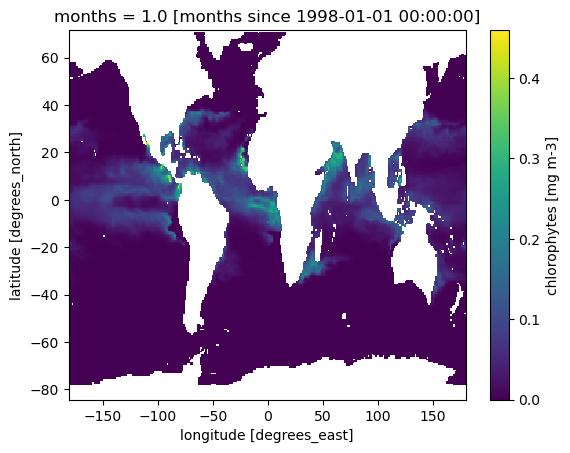

In [111]:
foo.chl[:,:,1].plot()

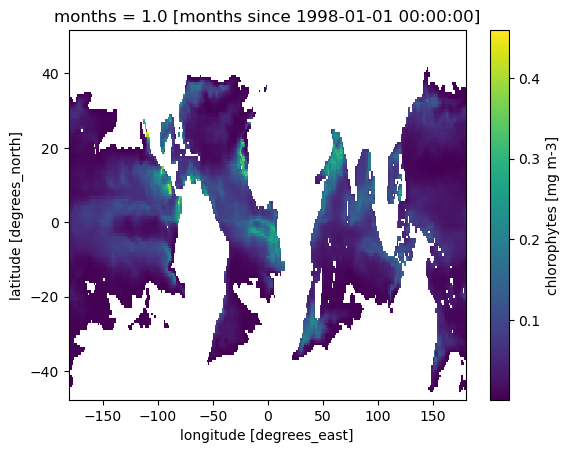

In [112]:
bar = foo['chl'].where(foo['chl']>0.001, drop=True)
bar[:,:,1].plot()

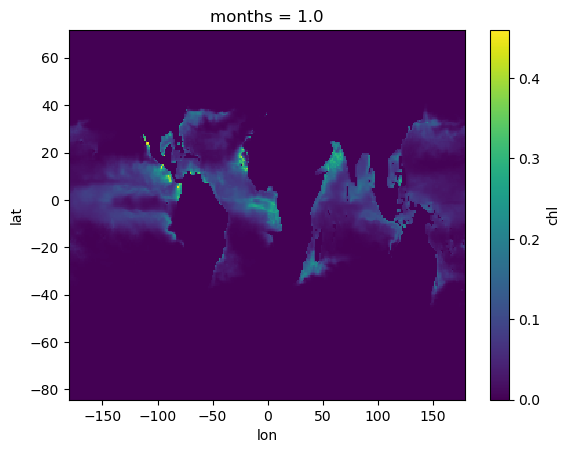

In [113]:
xr.where(foo.chl>0,foo.chl,0)[:,:,1].plot()

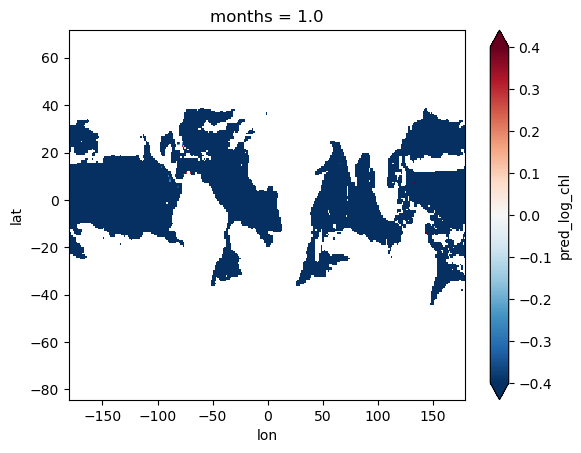

In [115]:
foo.pred_log_chl[:,:,1].plot(vmax=0.4)

TODO:
- show scatterplots with and without including env variables 

- rememeber for discussion- how these models w/ env variables can best predict phyto in a changing climate 